### Importando las bibliotecas a utilizar

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Importando los datos a clasificar

In [167]:
df = pd.read_csv("../../../../../../data_main/data.csv")
df.head()

,Edad,Salario,NivelEducativo,Genero,Ciudad,Hijos,TipoEmpleo,Compra
0,58,34592,Primaria,Mujer,North Judithbury,1,Autónomo,0
1,65,33434,Primaria,Mujer,East Jill,0,Empleado,0
2,31,50495,Primaria,Hombre,New Roberttown,4,Empresario,0
3,46,97236,Universitario,Hombre,East Jessetown,1,Empresario,1
4,39,56421,Secundaria,Hombre,Lake Debra,2,Empleado,0


In [168]:
# Separando las variables independientes y dependiente
X = df.drop(["Ciudad", "Compra"], axis=1)
y = df["Compra"]
y.value_counts()

Compra
1    3764
0    1236
Name: count, dtype: int64

## Balanceo de los datos con la cantidad mayor

In [169]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

y_ros.value_counts()

Compra
0    3764
1    3764
Name: count, dtype: int64

In [170]:
X_ros.shape, y_ros.shape

((7528, 6), (7528,))

### Separación de los datos de entrenamiento y prueba

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42, stratify=y_ros)

# Distribución de los valores de la variable dependiente
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(Compra
 0    0.5
 1    0.5
 Name: proportion, dtype: float64,
 Compra
 1    0.5
 0    0.5
 Name: proportion, dtype: float64)

### Construcción del pipeline para codificar variables categóricas

In [172]:
columns_cat = list(df.select_dtypes(include="object").columns)
columns_cat.remove("Ciudad")
print(columns_cat)
columns_num = list(df.select_dtypes(exclude="object").columns)
columns_num.remove("Compra")
print(columns_num)

['NivelEducativo', 'Genero', 'TipoEmpleo']
['Edad', 'Salario', 'Hijos']


In [173]:
preprocessor = ColumnTransformer([("cat", OneHotEncoder(), columns_cat),
                                  ("num", StandardScaler(), columns_num)])

pipeline_tree = Pipeline([("preprocessor", preprocessor),
                     ("clf_tree", DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, random_state=42))])

pipeline_rf = Pipeline([("preprocessor", preprocessor),
                        ("clf_rf", RandomForestClassifier(n_estimators=8, max_features=None, max_depth=5, min_samples_leaf=4, random_state=42))])

### Ajustando el pipeline con los datos de entrenamiento

In [174]:
pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['NivelEducativo', 'Genero',
                                                   'TipoEmpleo']),
                                                 ('num', StandardScaler(),
                                                  ['Edad', 'Salario',
                                                   'Hijos'])])),
                ('clf_tree',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=4,
                                        random_state=42))])

In [175]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['NivelEducativo', 'Genero',
                                                   'TipoEmpleo']),
                                                 ('num', StandardScaler(),
                                                  ['Edad', 'Salario',
                                                   'Hijos'])])),
                ('clf_rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        min_samples_leaf=4, n_estimators=8,
                                        random_state=42))])

Demostracion de la transformación de los datos de entrenamiento

In [176]:
# obteniendo los nombres de las columnas que utiliza el ohe
columns_cat_ohe = preprocessor.named_transformers_["cat"].get_feature_names_out(columns_cat)
print(columns_cat_ohe)

['NivelEducativo_Postgrado' 'NivelEducativo_Primaria'
 'NivelEducativo_Secundaria' 'NivelEducativo_Universitario'
 'Genero_Hombre' 'Genero_Mujer' 'TipoEmpleo_Autónomo'
 'TipoEmpleo_Desempleado' 'TipoEmpleo_Empleado' 'TipoEmpleo_Empresario']


In [177]:
# dataframe transformado por OneHotEncoder y StandardScalar
X_train_transformed = preprocessor.fit_transform(X_train)
features_names = np.concatenate([columns_cat_ohe, columns_num])
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=features_names)
X_train_transformed_df.head()

,NivelEducativo_Postgrado,NivelEducativo_Primaria,NivelEducativo_Secundaria,NivelEducativo_Universitario,Genero_Hombre,Genero_Mujer,TipoEmpleo_Autónomo,TipoEmpleo_Desempleado,TipoEmpleo_Empleado,TipoEmpleo_Empresario,Edad,Salario,Hijos
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.353961,1.681082,-1.298488
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.512273,-0.002337,0.809003
2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.740065,-0.497147,0.106506
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.933053,-1.318310,-1.298488
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.868766,0.309070,0.106506


## Creando los modelos de Decision Tree y Random Forest

In [178]:
# acceso al clasificador de árbol de decisión entrenado
tree_clf = pipeline_tree.named_steps["clf_tree"]
tree_clf

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, random_state=42)

In [179]:
# acceso al modelo de random forest entrenado
rf_clf = pipeline_rf.named_steps["clf_rf"]
rf_clf

RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=4,
                       n_estimators=8, random_state=42)

### Evaluación de los modelos

In [180]:
# StratifiedKFold: mantiene la misma proporción de clases que el conjunto de datos original
# cross_val_score: evaluación del rendimiento del modelo mediante validación cruzada.
from sklearn.model_selection import cross_val_score, StratifiedKFold

# configurando StratifiedKFold
skf_tree = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# realizando la validación cruzada utilizando el pipeline
cvs_tree = cross_val_score(pipeline_tree, X_train, y_train, cv=skf_tree, scoring="accuracy")
cvs_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=skf_rf, scoring="accuracy")
print("Decision Tree")
# resultados de la validación cruzada
print("Puntuaciones de validación cruzada:", np.round(cvs_tree, 3))
print("Media de las puntuaciones:", np.round(cvs_tree.mean(), 3))
# resultado con el set de prueba
print("Resultado con el set de prueba:", np.round(pipeline_tree.score(X_test, y_test),3))
print("="*50)
print("Random Forest")
# resultados de la validación cruzada
print("Puntuaciones de validación cruzada:", np.round(cvs_rf, 3))
print("Media de las puntuaciones:", np.round(cvs_rf.mean(), 3))
# resultado con el set de prueba
print("Resultado con el set de prueba:", np.round(pipeline_rf.score(X_test, y_test),3))

Decision Tree
Puntuaciones de validación cruzada: [0.822 0.832 0.826 0.814 0.808]
Media de las puntuaciones: 0.82
Resultado con el set de prueba: 0.831
Random Forest
Puntuaciones de validación cruzada: [0.83  0.841 0.836 0.822 0.809]
Media de las puntuaciones: 0.828
Resultado con el set de prueba: 0.835


In [181]:
# designanfo los nombres a las etiquetas numéricas
valores_unicos = np.unique(y_test)

if len(valores_unicos) == 2:
    guia = dict(zip(["No_compra", "Compra"], sorted(valores_unicos, reverse=True)))
else:
    raise ValueError("La variable dependiente no tiene exactamente dos clases.")
guia

{'No_compra': 1, 'Compra': 0}

### Gráfico de Decision Tree

Profundidad del árbol:  5
Número de hojas del árbol:  24


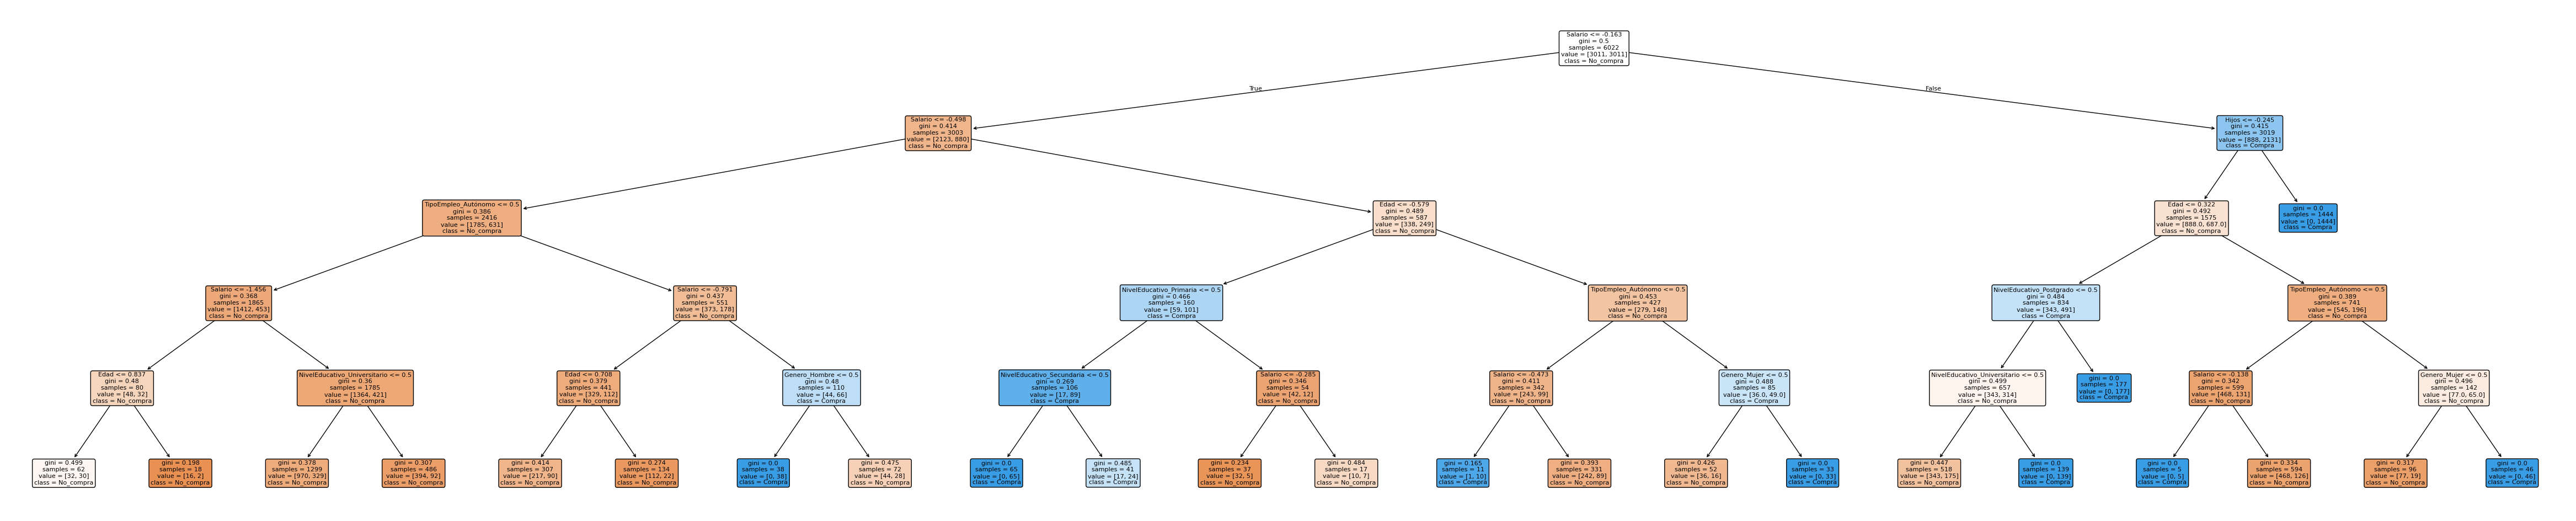

In [182]:
from sklearn.tree import plot_tree
# profundidad del árbol y el número de hojas del árbol
print('Profundidad del árbol: ', tree_clf.get_depth())
print('Número de hojas del árbol: ', tree_clf.get_n_leaves())

plt.figure(figsize=(60,12))
plot_tree(tree_clf, feature_names=features_names, class_names=list(guia.keys()), filled=True, rounded=True)
plt.show()

### Visualización de las características importantes del modelo de Decision Tree y Random Forest

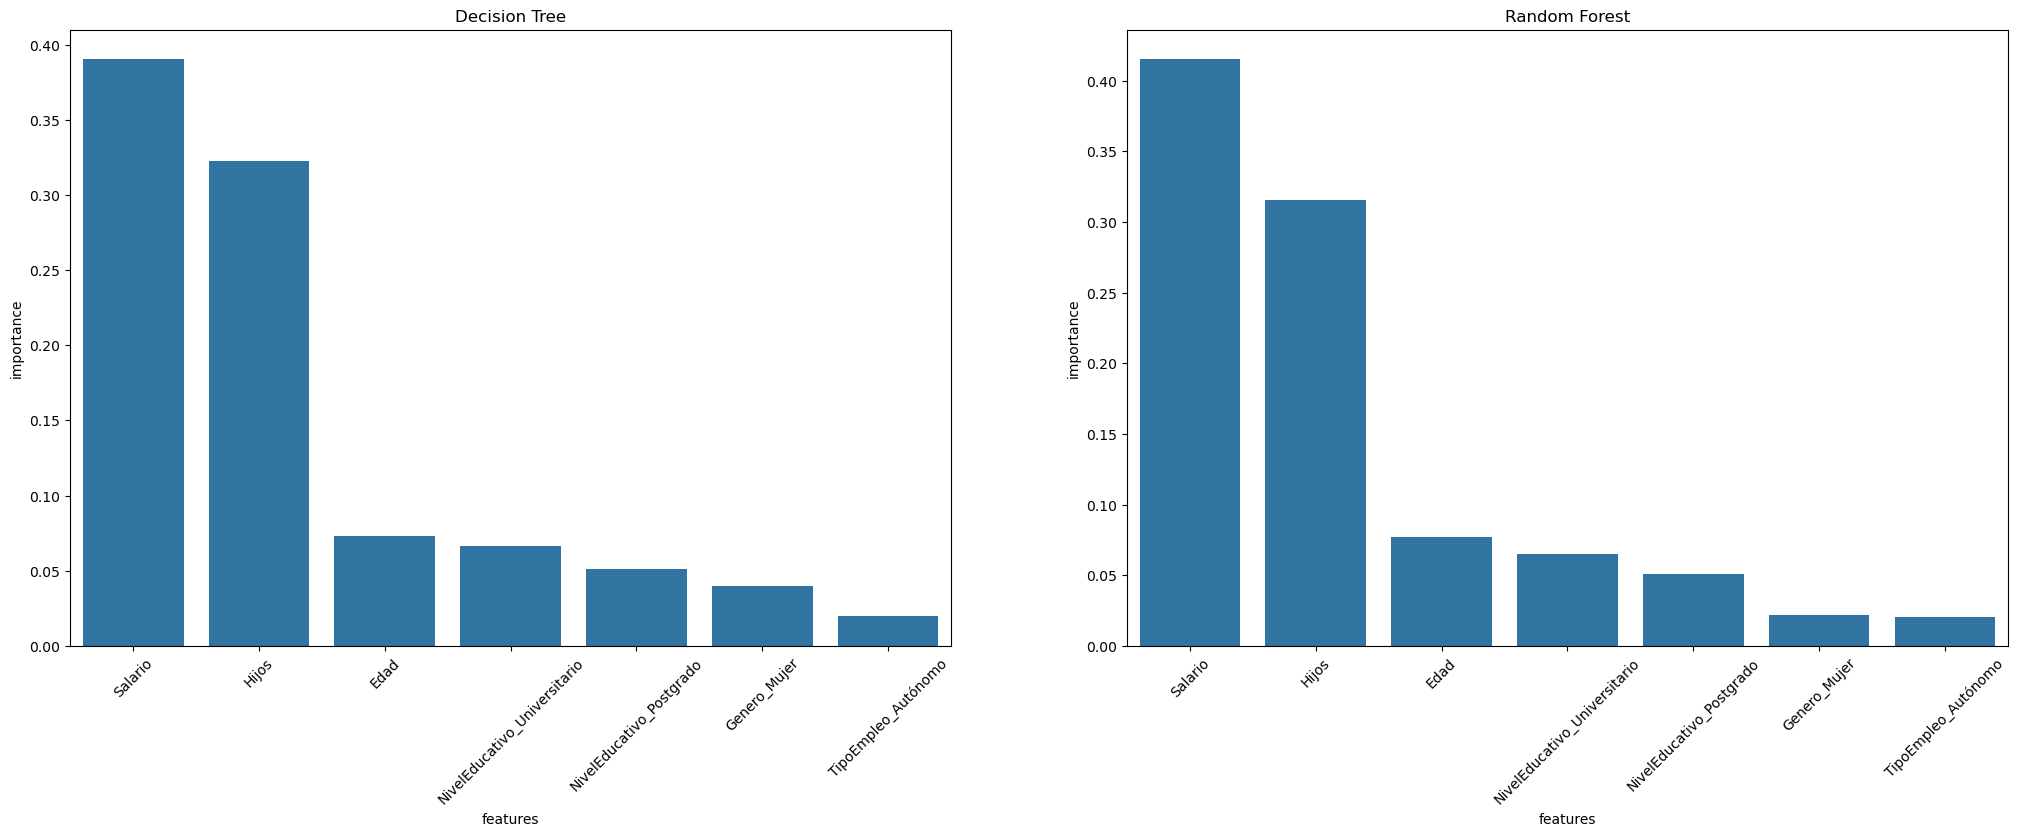

In [183]:
features_tree = pd.DataFrame({"features":features_names, "importance": tree_clf.feature_importances_})
features_tree = features_tree.sort_values("importance", ascending=False)
features_rf = pd.DataFrame({"features": features_names, "importance": rf_clf.feature_importances_})
features_rf = features_rf.sort_values("importance", ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(25, 8))
sns.barplot(features_tree.iloc[0:7], x="features", y="importance", ax=ax[0])
ax[0].set_xticks(range(7))
ax[0].set_xticklabels(features_tree.iloc[0:7]['features'], rotation=45)
ax[0].set_title("Decision Tree")
sns.barplot(features_rf.iloc[0:7], x="features", y="importance", ax=ax[1])
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(features_rf.iloc[0:7]['features'], rotation=45)
ax[1].set_title("Random Forest")
plt.show()

### Visualización de las características importantes del modelo Random Forest

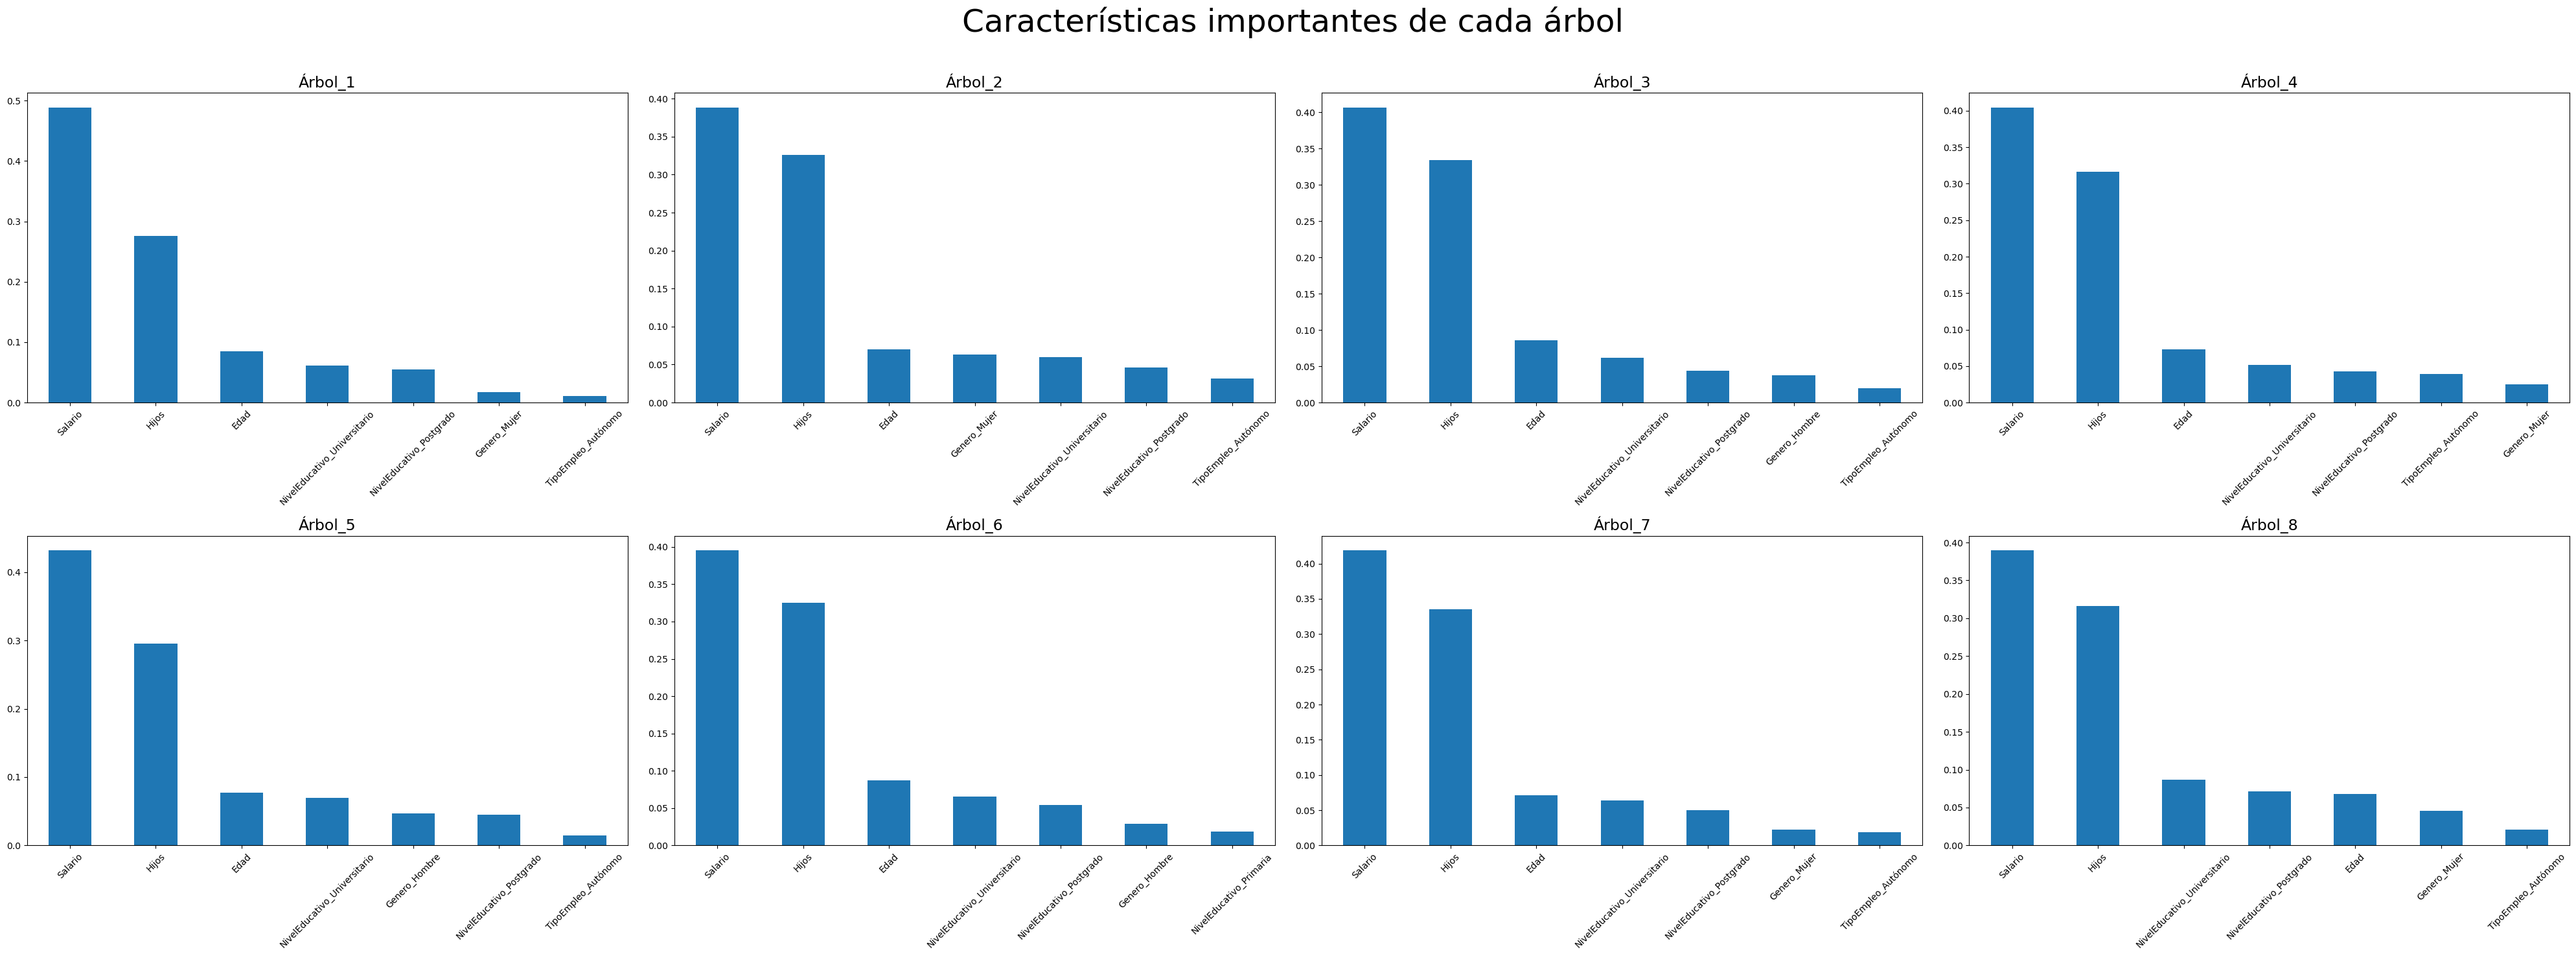

In [184]:
# Características importantes de cada modelo
features_rf = [modelo.feature_importances_ for modelo in rf_clf.estimators_]
features_rf = pd.DataFrame(features_rf, columns=features_names)

fig, ax = plt.subplots(2, 4, figsize=(40, 15))
ax = ax.flat
plt.suptitle("Características importantes de cada árbol\n", size=35)
for i in range(len(features_rf)):
    df_temp = features_rf.iloc[i,:].sort_values(ascending=False)
    df_temp = df_temp.head(7)
    df_temp.plot(kind="bar", ax=ax[i], legend=False)
    ax[i].set_title(f"Árbol_{i+1}", size=17)
    ax[i].set_xticklabels(df_temp.index, rotation=45)
plt.tight_layout()
plt.show()

### Predicción con el set de prueba y gráfica de la matriz de confusión

Reporte de clasificación Decision Tree
              precision    recall  f1-score   support

   No_compra       0.75      0.99      0.85       753
      Compra       0.99      0.67      0.80       753

    accuracy                           0.83      1506
   macro avg       0.87      0.83      0.83      1506
weighted avg       0.87      0.83      0.83      1506

Reporte de clasificación Random Fores
              precision    recall  f1-score   support

   No_compra       0.75      0.99      0.86       753
      Compra       0.99      0.68      0.80       753

    accuracy                           0.84      1506
   macro avg       0.87      0.84      0.83      1506
weighted avg       0.87      0.84      0.83      1506



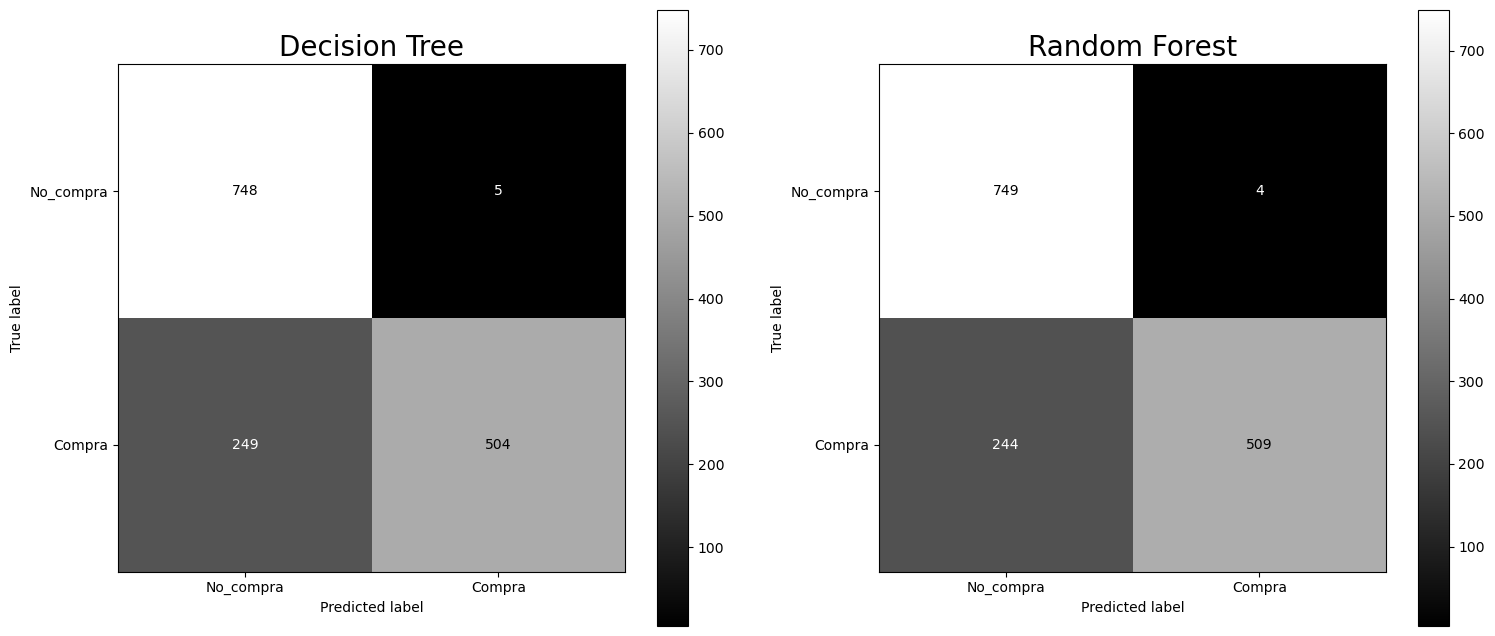

In [185]:
tree_predict = pipeline_tree.predict(X_test)
rf_predict = pipeline_rf.predict(X_test)
print("Reporte de clasificación Decision Tree")
print(classification_report(y_test, tree_predict, target_names=guia.keys()))
print("="*50)
print("Reporte de clasificación Random Fores")
print(classification_report(y_test, rf_predict, target_names=guia.keys()))
# Realizando la matriz de confusión
cm_tree = confusion_matrix(y_test, tree_predict)
cm_rf = confusion_matrix(y_test, rf_predict)
dist_rf = ConfusionMatrixDisplay(cm_rf, display_labels=guia.keys())
dist_tree = ConfusionMatrixDisplay(cm_tree, display_labels=guia.keys())

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].set_title("Decision Tree", size=20)
dist_tree.plot(cmap="gray", ax=ax[0])
ax[1].set_title("Random Forest", size=20)
dist_rf.plot(cmap="gray", ax=ax[1])
plt.show()

### Visualizando al mejor Árbol de Random Forest

In [190]:
mean_importances = np.mean(features_rf, axis=1)
most_important_tree_index = np.argmax(mean_importances)
# seleccionando el mejor árbol de decisiones
best_tree_rf = rf_clf.estimators_[most_important_tree_index]
best_tree_rf
     

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, random_state=1273642419)

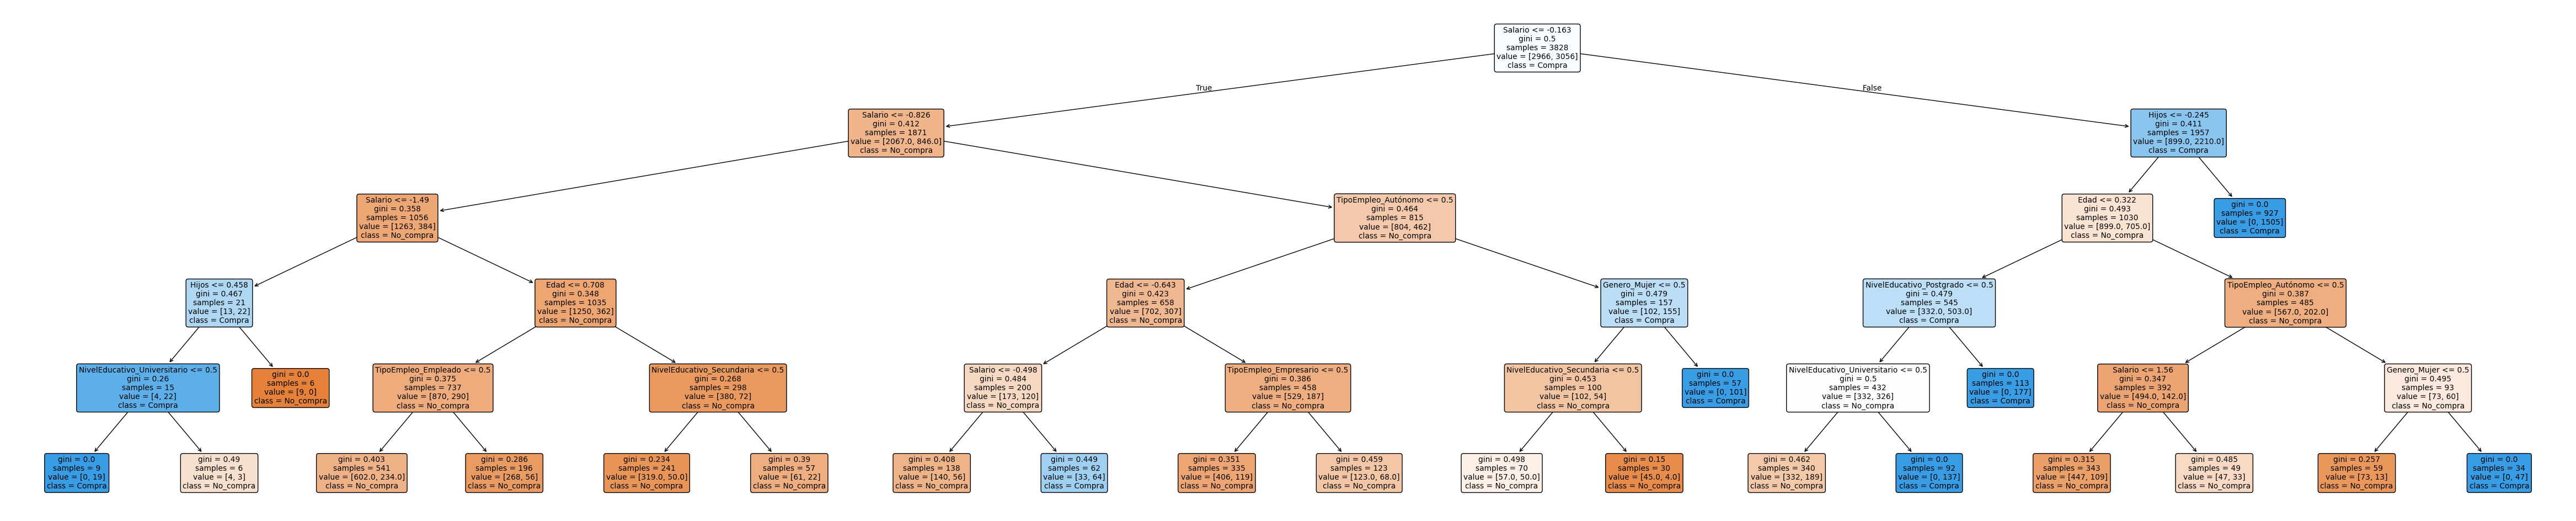

In [191]:
# graficando el árbol mas importante
plt.figure(figsize=(60,12))
plot_tree(best_tree_rf, feature_names=features_names, class_names=list(guia.keys()), filled=True, rounded=True)
plt.show()